In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

In [3]:
DATA_PATH = 'data/ecommerce_users.geojson'

In [4]:
municipalities = gpd.read_file(DATA_PATH)

In [7]:
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
from rtree import index
from tqdm import tqdm

# Step 1: Load and preprocess data
print("Step 1: Loading and preprocessing data...")
municipalities = municipalities.to_crs(epsg=6372)
municipalities['centroid'] = municipalities.centroid
municipalities['covered'] = False
print("Preprocessing complete.")
invalid_geometries = municipalities[~municipalities.is_valid]
municipalities['geometry'] = municipalities['geometry'].buffer(0)
from shapely.validation import make_valid
municipalities['geometry'] = municipalities['geometry'].apply(make_valid)
# Step 2: Generate candidate locations
print("Step 2: Generating candidate locations...")
# Assuming 'municipalities' is a pre-loaded GeoDataFrame
minx, miny, maxx, maxy = municipalities.total_bounds
x_coords = np.arange(minx, maxx, 20000)
y_coords = np.arange(miny, maxy, 20000)

# Create candidate points
candidate_points = [Point(x, y) for x in tqdm(x_coords, desc="Processing X-coords") for y in y_coords]
candidate_gdf = gpd.GeoDataFrame(geometry=candidate_points)

# Build spatial index on municipalities for faster lookup
municipalities_sindex = municipalities.sindex

# Filter points using spatial index
filtered_points = []
for point in tqdm(candidate_gdf.geometry, desc="Filtering Points"):
    possible_matches_index = list(municipalities_sindex.intersection(point.bounds))
    possible_matches = municipalities.iloc[possible_matches_index]
    if possible_matches.contains(point).any():
        filtered_points.append(point)

# Create GeoDataFrame from filtered points
candidate_gdf = gpd.GeoDataFrame(geometry=filtered_points)
print(f"Generated {len(candidate_gdf)} candidate points within municipalities.")

# Step 3: Compute coverage
print("Step 3: Computing coverage...")
# Build spatial index for municipalities
idx = index.Index()
for idx_mun, mun in tqdm(municipalities.iterrows(), total=len(municipalities), desc="Building spatial index"):
    idx.insert(idx_mun, mun.geometry.bounds)

candidate_gdf['coverage'] = 0
candidate_gdf['covered_municipalities'] = None

print("Calculating coverage for each candidate point...")
for idx_can, candidate in tqdm(candidate_gdf.iterrows(), total=len(candidate_gdf), desc="Coverage calculation"):
    buffer = candidate.geometry.buffer(30000)  # 30 km buffer
    covered_muns = [i for i in idx.intersection(buffer.bounds)]
    total_users = municipalities.loc[covered_muns, 'ECOMMERCE_USERS'].sum()
    candidate_gdf.at[idx_can, 'coverage'] = total_users
    candidate_gdf.at[idx_can, 'covered_municipalities'] = covered_muns

# Step 4: Greedy selection
print("Step 4: Starting greedy selection of centers...")
selected_centers = []
for i in tqdm(range(7), desc="Greedy selection"):
    # Select candidate with max coverage
    idx_max = candidate_gdf['coverage'].idxmax()
    selected_center = candidate_gdf.loc[idx_max]
    selected_centers.append(selected_center.geometry)
    
    # Mark municipalities as covered
    covered_muns = selected_center['covered_municipalities']
    municipalities.loc[covered_muns, 'covered'] = True
    
    # Remove covered users from candidates
    municipalities['ECOMMERCE_USERS'] = municipalities.apply(
        lambda row: 0 if row.covered else row.ECOMMERCE_USERS, axis=1)
    
    # Recompute coverage for all candidates (or optimize by only updating affected candidates)
    # For simplicity, recompute all
    for idx_can, candidate in tqdm(candidate_gdf.iterrows(), total=len(candidate_gdf), desc=f"Recomputing coverage after selection {i+1}"):
        covered_muns = candidate['covered_municipalities']
        total_users = municipalities.loc[covered_muns, 'ECOMMERCE_USERS'].sum()
        candidate_gdf.at[idx_can, 'coverage'] = total_users

# Step 5: Output results
print("Step 5: Saving results to file...")
centers_gdf = gpd.GeoDataFrame(geometry=selected_centers)
centers_gdf.to_file('selected_centers.shp')
print("Process complete. Results saved to 'selected_centers.shp'.")


Step 1: Loading and preprocessing data...
Preprocessing complete.
Step 2: Generating candidate locations...


Filtering Points: 100%|██████████| 16218/16218 [00:31<00:00, 517.69it/s] 


Generated 4854 candidate points within municipalities.
Step 3: Computing coverage...


Building spatial index: 100%|██████████| 2469/2469 [00:00<00:00, 9342.74it/s] 


Calculating coverage for each candidate point...


Coverage calculation:   0%|          | 0/4854 [00:00<?, ?it/s]/tmp/ipykernel_38590/834605377.py:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '409699.33999999997' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  candidate_gdf.at[idx_can, 'coverage'] = total_users
Coverage calculation: 100%|██████████| 4854/4854 [00:02<00:00, 2000.02it/s]


Step 4: Starting greedy selection of centers...


Greedy selection: 100%|██████████| 7/7 [00:11<00:00,  1.70s/it]

Step 5: Saving results to file...
Process complete. Results saved to 'selected_centers.shp'.



/home/lornarthebreton/miniconda3/envs/dataton_2024/lib/python3.12/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


In [15]:
# Since geographical coordinates are in degrees, it's better to project the data to a CRS that uses meters
# For Mexico, UTM Zone 14N (EPSG:32614) is commonly used, but confirm the appropriate UTM zone for your data
metric_crs = 'EPSG:6372'  # Replace with the correct EPSG code if necessary

# Reproject to metric CRS
municipalities = municipalities.to_crs(metric_crs)
centers_gdf = centers_gdf.to_crs(metric_crs)

# Create 30 km (30,000 meters) coverage buffers
centers_gdf['coverage_area'] = centers_gdf.geometry.buffer(30000)


In [11]:
import contextily as ctx  # For adding basemaps

In [17]:
# Confirm and set CRS if missing
if municipalities.crs is None:
    municipalities.set_crs("EPSG:4326", inplace=True)  # Assuming it's in WGS84
if centers_gdf.crs is None:
    centers_gdf.set_crs("EPSG:4326", inplace=True)

# Reproject both to EPSG:3857 for use with contextily basemaps
municipalities = municipalities.to_crs("EPSG:3857")
centers_gdf = centers_gdf.to_crs("EPSG:3857")


In [21]:
centers_gdf = gpd.read_file('selected_centers.shp')

In [27]:
centers_gdf

,FID,geometry
0,0,POINT (2791292.029 839149.063)
1,1,POINT (2651292.029 1519149.063)
2,2,POINT (2391292.029 939149.063)
3,3,POINT (2591292.029 959149.063)
4,4,POINT (2911292.029 799149.063)
5,5,POINT (2771292.029 779149.063)
6,6,POINT (2671292.029 919149.063)


In [28]:
centers_gdf = centers_gdf.set_crs("EPSG:3857")

In [2]:
import geopandas as gpd

In [3]:
municipalities = gpd.read_file('data/ecommerce_users.geojson')

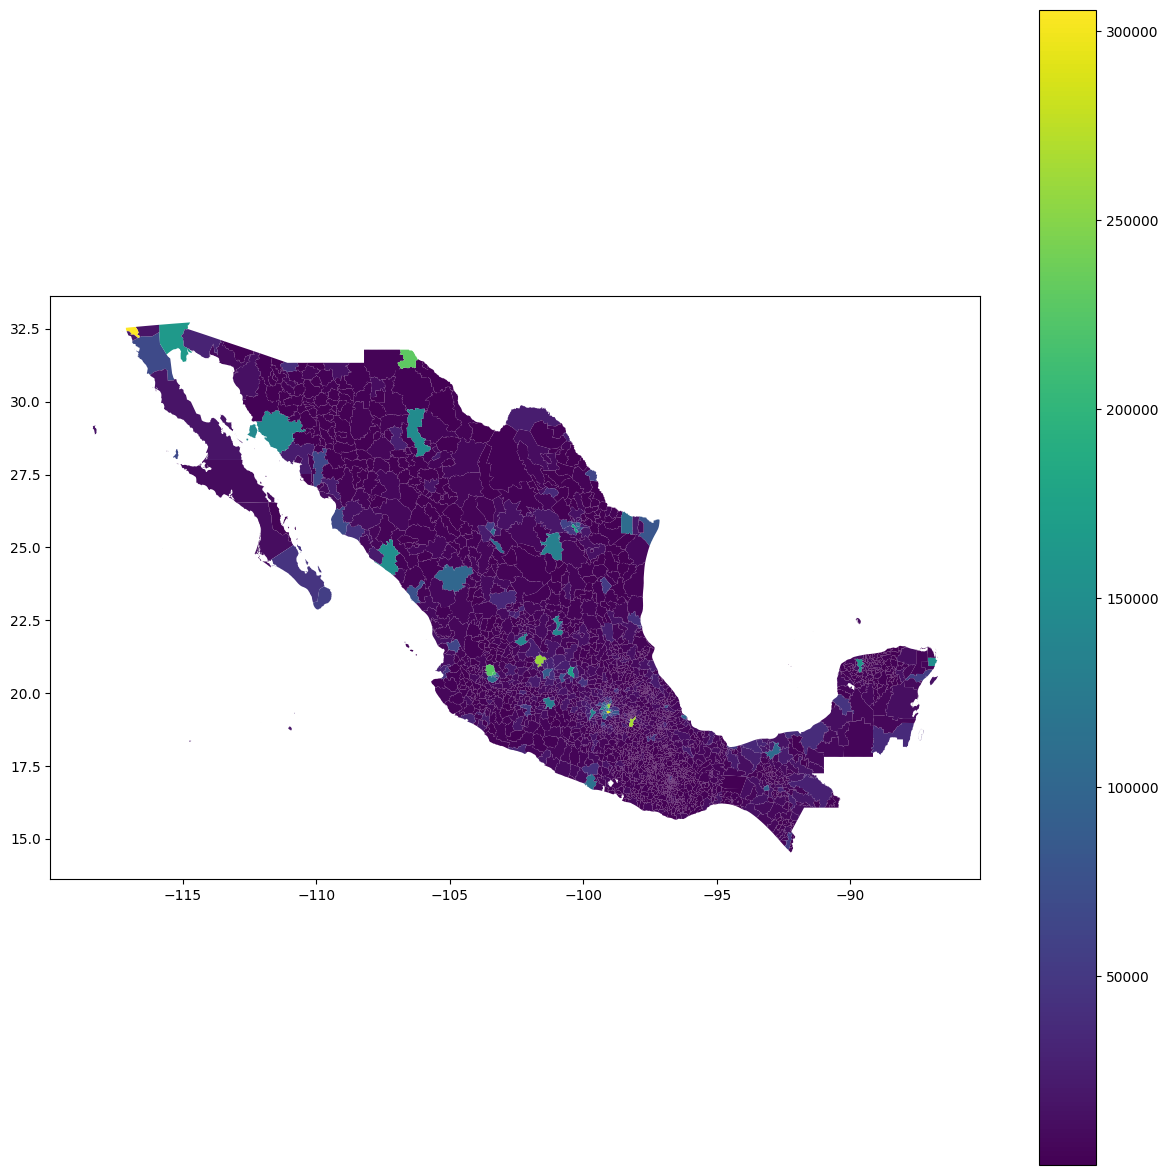

In [33]:
municipalities.plot(column='ECOMMERCE_USERS', legend=True, figsize=(15, 15))
plt.savefig('municipalities.png')

In [7]:
municipalities

,CVE_ENT,CVE_MUN,ENTIDAD,NOM_ENT,MUN,NOM_MUN,ECOMMERCE_USERS,LATITUD,LONGITUD,geometry,centroid,latitude,longitude
0,01,001,01,Aguascalientes,001,Aguascalientes,141927.50,"21°52'47.362"" N","102°17'45.768"" W","POLYGON ((-102.35394 21.63596, -102.36687 21.6...",POINT (-102.2958 21.81144),21.811444,-102.295801
1,01,002,01,Aguascalientes,002,Asientos,6893.34,"22°14'17.941"" N","102°05'21.390"" W","POLYGON ((-102.10368 22.05741, -102.10641 22.0...",POINT (-102.04564 22.12651),22.126508,-102.045638
2,01,003,01,Aguascalientes,003,Calvillo,7967.48,"21°50'48.866"" N","102°43'07.502"" W","POLYGON ((-102.65297 21.76464, -102.65461 21.7...",POINT (-102.7049 21.90069),21.900694,-102.704904
3,01,004,01,Aguascalientes,004,Cosío,2299.59,"22°21'59.071"" N","102°18'00.159"" W","POLYGON ((-102.23979 22.35306, -102.23979 22.3...",POINT (-102.29704 22.36063),22.360627,-102.297042
4,01,005,01,Aguascalientes,005,Jesús María,18538.44,"21°57'40.582"" N","102°20'36.299"" W","POLYGON ((-102.41774 21.88815, -102.41794 21.8...",POINT (-102.44565 21.93212),21.932118,-102.445653
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2464,32,054,32,Zacatecas,054,Villa Hidalgo,2546.84,"22°21'25.518"" N","101°42'45.356"" W","POLYGON ((-101.68247 22.32571, -101.68336 22.3...",POINT (-101.71432 22.40736),22.407358,-101.714319
2465,32,055,32,Zacatecas,055,Villanueva,4334.08,"22°21'15.331"" N","102°53'01.414"" W","POLYGON ((-102.86828 22.0367, -102.86849 22.03...",POINT (-102.85151 22.29827),22.298265,-102.851508
2466,32,056,32,Zacatecas,056,Zacatecas,22736.63,"22°46'33.946"" N","102°34'18.611"" W","POLYGON ((-102.55515 22.71401, -102.55457 22.7...",POINT (-102.67806 22.73574),22.735738,-102.678064
2467,32,057,32,Zacatecas,057,Trancoso,2745.34,"22°44'07.401"" N","102°21'57.736"" W","POLYGON ((-102.32078 22.68806, -102.32355 22.6...",POINT (-102.312 22.75563),22.755629,-102.312003


In [31]:
import folium
import geopandas as gpd
from folium.plugins import HeatMap
from shapely.geometry import Point

# Load your main GeoDataFrame and ensure it's in EPSG:4326
gdf = municipalities # Replace with actual file path
if gdf.crs != "EPSG:4326":
    gdf = gdf.to_crs("EPSG:4326")

# Create a GeoDataFrame for the marker coordinates
# Replace "EPSG:xxxx" with the actual CRS of your coordinates, if known
marker_crs = "EPSG:4326"  # Assuming they are already in EPSG:4326, but replace if needed

# Define your original marker coordinates with their original CRS
marker_data = [
    {"name": "Point 1", "coords": Point(-96.8, 18.7)},    # Replace with actual CRS if different
    {"name": "Point 2", "coords": Point(-100.00001, 19.4)},
    {"name": "Point 3", "coords": Point(-102.6, 22.73)},
    {"name": "Point 4", "coords": Point(-100.9, 24.24)},
    {"name": "Point 5", "coords": Point(-116.7, 31.9)},
    {"name": "Point 6", "coords": Point(-103.3589, 20.5739)},
    {"name": "Point 7", "coords": Point(-99.2050, 19.5660)},
    {"name": "Point 8", "coords": Point(-98.3750, 19.2000)},
]

# Create a GeoDataFrame for these points
marker_gdf = gpd.GeoDataFrame(marker_data, geometry='coords', crs=marker_crs)

# Reproject marker coordinates to EPSG:4326 if they are not already
if marker_gdf.crs != "EPSG:4326":
    marker_gdf = marker_gdf.to_crs("EPSG:4326")

# Extract latitude and longitude from the reprojected points
marker_gdf['latitude'] = marker_gdf.geometry.y
marker_gdf['longitude'] = marker_gdf.geometry.x

# Prepare heatmap data from the main GeoDataFrame
gdf['centroid'] = gdf.geometry.centroid
gdf['latitude'] = gdf.centroid.y
gdf['longitude'] = gdf.centroid.x
heat_data = [
    [row['latitude'], row['longitude'], row['ECOMMERCE_USERS']]
    for index, row in gdf.iterrows()
    if not pd.isnull(row['latitude']) and not pd.isnull(row['longitude']) and not pd.isnull(row['ECOMMERCE_USERS'])
]

# Create the Folium map
starting_location = [23.0, -102.0]
map = folium.Map(location=starting_location, zoom_start=6)

# Add heatmap layer
HeatMap(heat_data, radius=10, max_zoom=13).add_to(map)

# Add the reprojected markers to the map
for _, row in marker_gdf.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['name'],
        tooltip=row['name']
    ).add_to(map)

# Add Layer Control
folium.LayerControl().add_to(map)

# Save the map
map.save("converted_markers_map.html")


/tmp/ipykernel_54815/157145331.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf.geometry.centroid
/tmp/ipykernel_54815/157145331.py:40: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['latitude'] = gdf.centroid.y
/tmp/ipykernel_54815/157145331.py:41: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['longitude'] = gdf.centroid.x


In [12]:
print(municipalities.crs)

EPSG:4326
